<a href="https://colab.research.google.com/github/paarthpatel10/dl/blob/main/Forecasting_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

## Loading the DATA of Business-1 Cluster-0

In [ ]:
data = pd.read_csv('/content/B1_c0.csv')

## RNN

#### Sorting by date

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

data = data[['Date', 'sentiment_score']].dropna()

#### Spliting the data

In [ ]:
train_data = data[data['Date'].dt.year < 2019]
test_data = data[data['Date'].dt.year == 2019]

#### Sclaing

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data['sentiment_score'] = scaler.fit_transform(train_data[['sentiment_score']])
test_data['sentiment_score'] = scaler.transform(test_data[['sentiment_score']])

#### Preparing Data For RNN input

In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

#### Creating Sequence and convering it to tensors

In [ ]:
seq_length = 5
X_train, y_train = create_sequences(train_data['sentiment_score'].values, seq_length)
X_test, y_test = create_sequences(test_data['sentiment_score'].values, seq_length)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

#### Defining the Model

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(SentimentRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

#### Initializing the model, loss function, and Optimizer

In [ ]:
model = SentimentRNN(input_size=1, hidden_size=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#### Defining the parameters and batching

In [ ]:
num_epochs = 50
batch_size = 64

train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

#### Training and Evaluating

Epoch [10/50], Loss: 0.0488
Epoch [20/50], Loss: 0.0333
Epoch [30/50], Loss: 0.1732
Epoch [40/50], Loss: 0.1386
Epoch [50/50], Loss: 0.0384
Test MSE: 0.0184905044734478
Test MAE: 0.11578269302845001
Test RMSE: 0.1359797943572787
Test R2: 0.31477779150009155


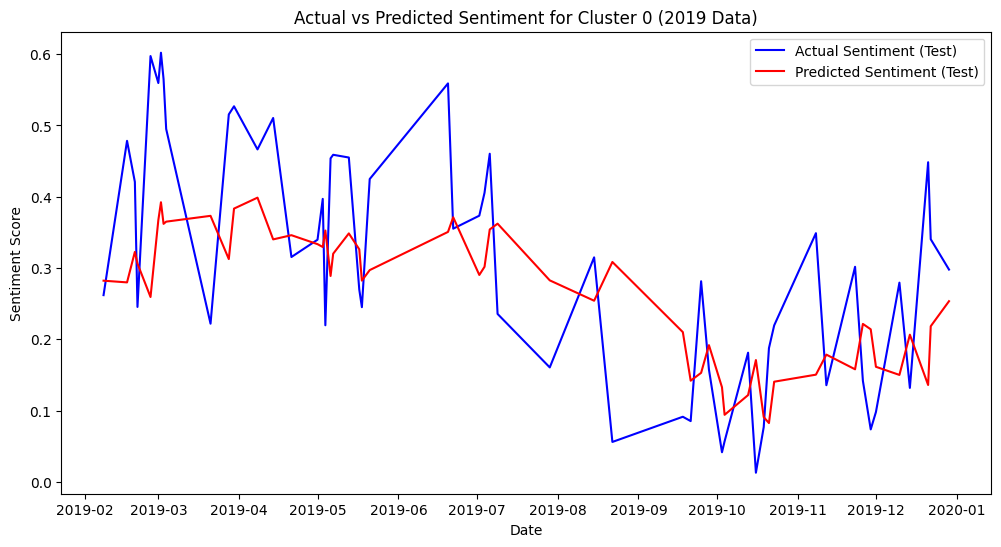

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.unsqueeze(-1)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y.unsqueeze(-1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    test_preds = []
    test_actuals = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.unsqueeze(-1)
        output = model(batch_x)
        test_preds.append(output)
        test_actuals.append(batch_y)

    test_preds = torch.cat(test_preds).numpy()
    test_actuals = torch.cat(test_actuals).numpy()

test_preds = scaler.inverse_transform(test_preds.reshape(-1, 1))
test_actuals = scaler.inverse_transform(test_actuals.reshape(-1, 1))


test_preds = scaler.inverse_transform(test_preds)
test_actuals = scaler.inverse_transform(test_actuals)


mse_test = mean_squared_error(test_actuals, test_preds)
mae_test = mean_absolute_error(test_actuals, test_preds)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(test_actuals, test_preds)

print(f"Test MSE: {mse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R2: {r2_test}")

plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'][seq_length:], test_actuals, label='Actual Sentiment (Test)', color='blue')
plt.plot(test_data['Date'][seq_length:], test_preds, label='Predicted Sentiment (Test)', color='red')
plt.legend()
plt.title('Actual vs Predicted Sentiment for Cluster 0 (2019 Data)')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

## LSTM

#### Preparing Data For LSTM input

In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

#### Creating Sequence and convering it to tensors

In [ ]:
seq_length = 10
X, y = create_sequences(data['sentiment_score'].values, seq_length)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

#### Spliting the data

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#### Defining the Model

In [ ]:
class AutoRegressiveLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(AutoRegressiveLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

#### Initializing the model, loss function, and Optimizer

In [ ]:
model = AutoRegressiveLSTM(input_size=1, hidden_size=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Defining the parameters and batching

In [ ]:
num_epochs = 50
batch_size = 64

train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

#### Training and Evaluating

Epoch [10/50], Loss: 0.0300
Epoch [20/50], Loss: 0.0351
Epoch [30/50], Loss: 0.0321
Epoch [40/50], Loss: 0.0341
Epoch [50/50], Loss: 0.0339
Test MSE: 0.016488898545503616
Test MAE: 0.10859604179859161
Test RMSE: 0.1284091061627002
Test R2: 0.33781135082244873


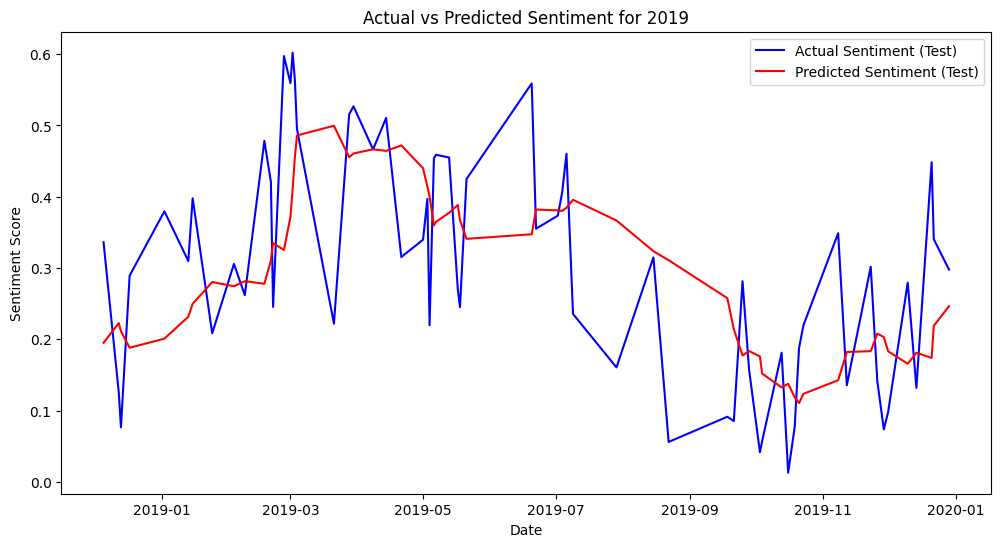

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.unsqueeze(-1)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y.unsqueeze(-1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    test_preds = []
    test_actuals = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.unsqueeze(-1)
        output = model(batch_x)
        test_preds.append(output)
        test_actuals.append(batch_y)

    test_preds = torch.cat(test_preds).numpy()
    test_actuals = torch.cat(test_actuals).numpy()


test_preds = scaler.inverse_transform(test_preds.reshape(-1, 1))
test_actuals = scaler.inverse_transform(test_actuals.reshape(-1, 1))

mse_test = mean_squared_error(test_actuals, test_preds)
mae_test = mean_absolute_error(test_actuals, test_preds)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(test_actuals, test_preds)

print(f"Test MSE: {mse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R2: {r2_test}")

plt.figure(figsize=(12, 6))
plt.plot(data['Date'][len(data) - len(test_actuals):], test_actuals, label='Actual Sentiment (Test)', color='blue')
plt.plot(data['Date'][len(data) - len(test_preds):], test_preds, label='Predicted Sentiment (Test)', color='red')
plt.legend()
plt.title('Actual vs Predicted Sentiment for 2019')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

### CNN +LSTM

In [ ]:
seq_length = 5
X, y = create_sequences(data['sentiment_score'].values, seq_length)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

#### Spliting the data

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#### Defining the model

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size=1, cnn_out_channels=16, lstm_hidden_size=64, num_layers=1):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=cnn_out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=cnn_out_channels, out_channels=cnn_out_channels, kernel_size=3, padding=1)

        self.lstm = nn.LSTM(cnn_out_channels, lstm_hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):

        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])

        return out

#### Initializing the model, loss function, and optimizer

In [ ]:
model = CNNLSTM(input_size=1, cnn_out_channels=16, lstm_hidden_size=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Defining parameters and batching

In [ ]:
num_epochs = 50
batch_size = 64

train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

#### Training and Evaluating the model

Epoch [10/50], Loss: 0.0258
Epoch [20/50], Loss: 0.0224
Epoch [30/50], Loss: 0.0202
Epoch [40/50], Loss: 0.0165
Epoch [50/50], Loss: 0.0220
Test MSE: 0.02736530266702175
Test MAE: 0.13320276141166687
Test RMSE: 0.16542461324428645
Test R2: -0.11610627174377441


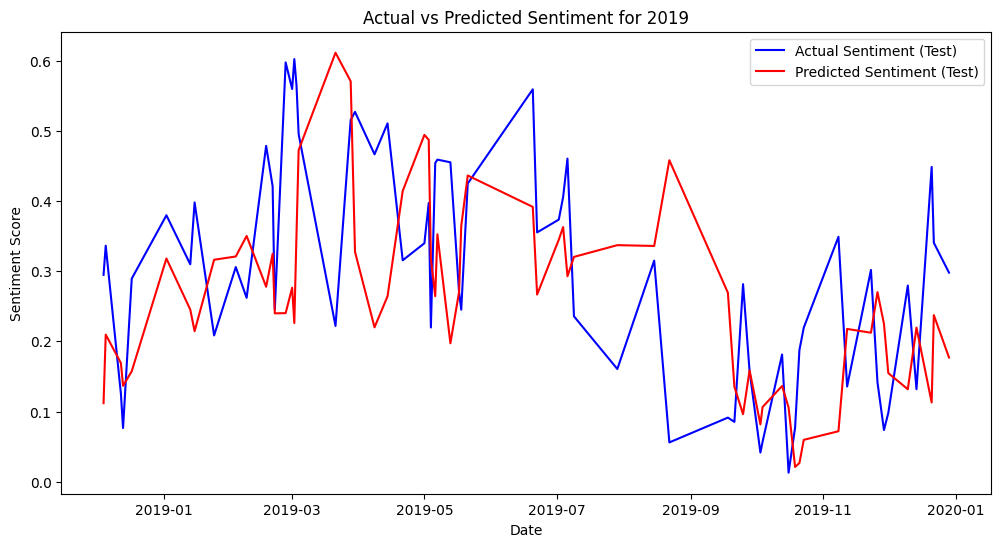

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.unsqueeze(-1)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y.unsqueeze(-1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    test_preds = []
    test_actuals = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.unsqueeze(-1)
        output = model(batch_x)
        test_preds.append(output)
        test_actuals.append(batch_y)

    test_preds = torch.cat(test_preds).numpy()
    test_actuals = torch.cat(test_actuals).numpy()


test_preds = scaler.inverse_transform(test_preds.reshape(-1, 1))
test_actuals = scaler.inverse_transform(test_actuals.reshape(-1, 1))


mse_test = mean_squared_error(test_actuals, test_preds)
mae_test = mean_absolute_error(test_actuals, test_preds)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(test_actuals, test_preds)

print(f"Test MSE: {mse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R2: {r2_test}")


plt.figure(figsize=(12, 6))
plt.plot(data['Date'][len(data) - len(test_actuals):], test_actuals, label='Actual Sentiment (Test)', color='blue')
plt.plot(data['Date'][len(data) - len(test_preds):], test_preds, label='Predicted Sentiment (Test)', color='red')
plt.legend()
plt.title('Actual vs Predicted Sentiment for 2019')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()


## Seq2Seq

# Prepareing data for the Seq2Seq model

In [ ]:
def prepare_for_model(sequences, forecast_steps=3, input_steps=10):
    X_values, X_timestamps, y_values = [], [], []
    for df in sequences:
        for i in range(len(df) - input_steps - forecast_steps + 1):
            x_vals = df['sentiment_score'].iloc[i:i+input_steps].values
            x_times = df['date'].iloc[i:i+input_steps].values
            y_vals = df['sentiment_score'].iloc[i+input_steps:i+input_steps+forecast_steps].values
            X_values.append(x_vals)
            X_timestamps.append(x_times)
            y_values.append(y_vals)
    X_values = torch.tensor(np.expand_dims(X_values, axis=-1), dtype=torch.float32)
    X_timestamps = torch.tensor(np.expand_dims(X_timestamps, axis=-1), dtype=torch.float32)
    y_values = torch.tensor(np.expand_dims(y_values, axis=-1), dtype=torch.float32)
    return X_values, X_timestamps, y_values

X_values, X_timestamps, y_values = prepare_for_model(data)

train_df = data[data['Date'].dt.year < 2019].copy()
test_df = data[data['Date'].dt.year == 2019].copy()

train_df = train_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})
test_df = test_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})

X_values_train, X_timestamps_train, y_values_train = prepare_for_model([train_df])
X_values_test, X_timestamps_test, y_values_test = prepare_for_model([test_df])


# Defining Time Aware Attention class

In [ ]:
class TimeAwareAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.time_decay = nn.Linear(1, hidden_dim)

    def forward(self, decoder_hidden, encoder_outputs, time_deltas):
        Q = self.query_proj(decoder_hidden).unsqueeze(1)
        K = self.key_proj(encoder_outputs)
        decay = torch.exp(-torch.abs(self.time_decay(time_deltas)))
        attn_scores = (Q * K * decay).sum(-1)
        attn_weights = F.softmax(attn_scores, dim=-1).unsqueeze(-1)
        context = (attn_weights * encoder_outputs).sum(1)
        return context

# Defining the Encoder and Decoder with dropout


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, dropout=dropout_rate)

    def forward(self, x):
        output, hidden = self.gru(x)
        return output, hidden.squeeze(0)

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRUCell(input_dim, hidden_dim)
        self.attn = TimeAwareAttention(hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, decoder_input, hidden, encoder_outputs, time_deltas):
        hidden = self.gru(decoder_input, hidden)
        context = self.attn(hidden, encoder_outputs, time_deltas)
        combined = torch.cat([hidden, context], dim=-1)
        output = self.fc(combined)
        return output, hidden

# Defining the Sequence to Sequence TimeAware class


In [ ]:
class Seq2SeqTimeAware(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)

    def forward(self, values, time_stamps, target=None, forecast_steps=3, teacher_forcing=True):
        B, T, _ = values.shape
        deltas = time_stamps[:, 1:, :] - time_stamps[:, :-1, :]
        deltas = torch.cat([deltas[:, 0:1, :], deltas], dim=1)
        enc_input = torch.cat([values, deltas], dim=-1)
        enc_outputs, hidden = self.encoder(enc_input)
        preds = []
        last_output = values[:, -1, :]
        last_time = time_stamps[:, -1, :]
        for step in range(forecast_steps):
            next_time = last_time + 1.0
            delta = (next_time.unsqueeze(1) - time_stamps).expand(-1, T, -1)
            dec_input = torch.cat([last_output, next_time - last_time], dim=-1)
            pred, hidden = self.decoder(dec_input, hidden, enc_outputs, delta)
            preds.append(pred.unsqueeze(1))
            if teacher_forcing and target is not None and step < target.shape[1]:
                last_output = target[:, step, :]
            else:
                last_output = pred.detach()
            last_time = next_time
        return torch.cat(preds, dim=1)



# Define the PrintEveryN callback

In [ ]:
class PrintEveryN:
    def __init__(self, N):
        self.N = N

    def __call__(self, epoch, train_loss, val_loss):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch+1:03}: Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


# Early stopping class

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.best_weights = None

    def check(self, val_loss, model):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def restore_best_weights(self, model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)


# Initializing Model, Loss function and optimizer

In [ ]:
model = Seq2SeqTimeAware(input_dim=2, hidden_dim=256)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
criterion = torch.nn.MSELoss()
forecast_steps = y_values_train.shape[1]

# Training and Evaluating the model

In [ ]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    preds = model(X_values_train, X_timestamps_train, target=y_values_train,
                  forecast_steps=forecast_steps, teacher_forcing=True)
    train_loss = criterion(preds, y_values_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_values_val, X_timestamps_val, target=None,
                          forecast_steps=forecast_steps, teacher_forcing=False)
        val_loss = criterion(val_preds, y_values_val).item()

    print_callback(epoch, train_loss.item(), val_loss)

    if early_stopping.check(val_loss, model):
        early_stopping.restore_best_weights(model)
        break

model.eval()
with torch.no_grad():
    preds = model(X_values_test, X_timestamps_test,
                  forecast_steps=forecast_steps, teacher_forcing=False)
    preds_np = preds.numpy().flatten()
    true_np = y_values_test.numpy().flatten()

Epoch 010: Loss = 0.0226, Val Loss = 0.0180
Epoch 020: Loss = 0.0185, Val Loss = 0.0161
Epoch 030: Loss = 0.0153, Val Loss = 0.0141
Epoch 040: Loss = 0.0138, Val Loss = 0.0152


# Evaluate the model on test data

In [ ]:
r2 = r2_score(true_np, preds_np)
mse = mean_squared_error(true_np, preds_np)
mae = mean_absolute_error(true_np, preds_np)
rmse = np.sqrt(mse)
ssip = np.sum((true_np - preds_np) ** 2)

print(f"\nEvaluation Metrics on Test Set (2019):")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"SSIP: {ssip:.4f}")



Evaluation Metrics on Test Set (2019):
R² Score: 0.7005
MSE: 0.0182
MAE: 0.1069
RMSE: 0.1348
SSIP: 1.0725


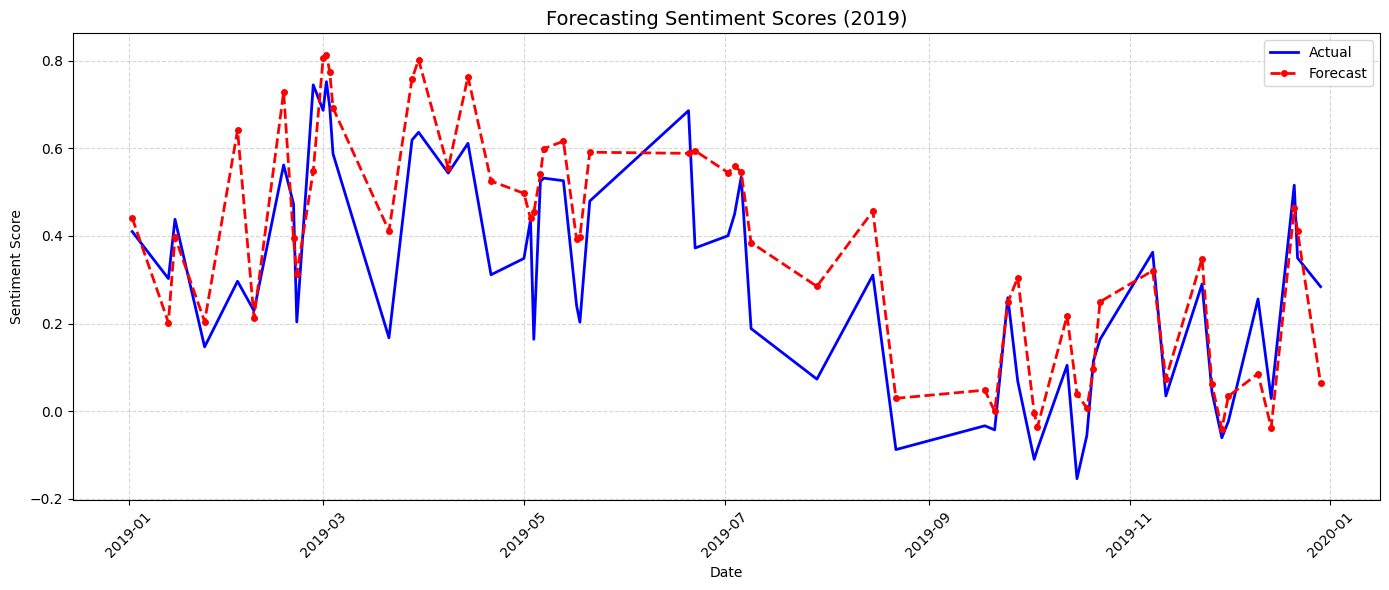

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_data['Date'], y_test, label='Actual', color='blue', linewidth=2)
plt.plot(test_data['Date'], y_pred, label='Forecast', color='red', linewidth=2, linestyle='--', marker='o', markersize=4)
plt.title('Forecasting Sentiment Scores (2019)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


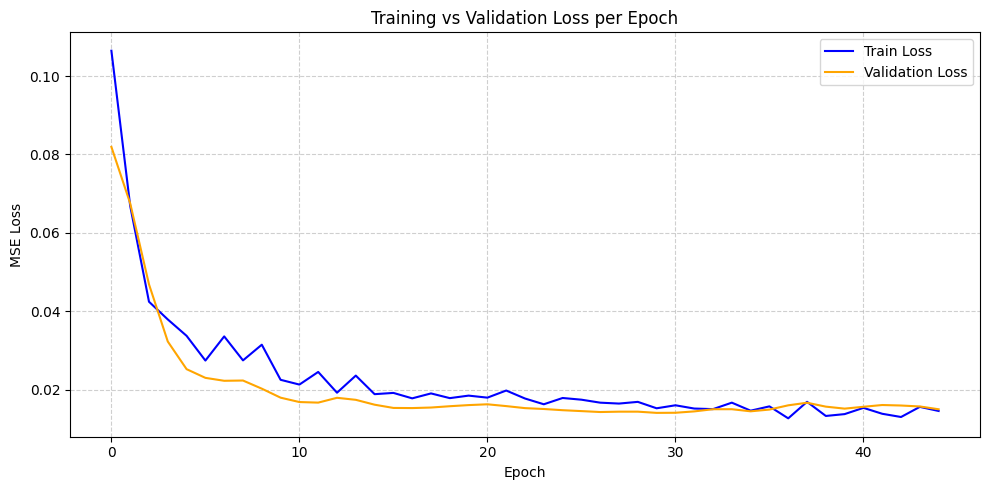

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Loading the Data of Businees-1 Cluster-2

In [ ]:
data = pd.read_csv('/content/B1_c0.csv')

# Training and Evaluating the model

# Prepareing data for the Seq2Seq model

In [ ]:
def prepare_for_model(sequences, forecast_steps=3, input_steps=10):
    X_values, X_timestamps, y_values = [], [], []
    for df in sequences:
        for i in range(len(df) - input_steps - forecast_steps + 1):
            x_vals = df['sentiment_score'].iloc[i:i+input_steps].values
            x_times = df['date'].iloc[i:i+input_steps].values
            y_vals = df['sentiment_score'].iloc[i+input_steps:i+input_steps+forecast_steps].values
            X_values.append(x_vals)
            X_timestamps.append(x_times)
            y_values.append(y_vals)
    X_values = torch.tensor(np.expand_dims(X_values, axis=-1), dtype=torch.float32)
    X_timestamps = torch.tensor(np.expand_dims(X_timestamps, axis=-1), dtype=torch.float32)
    y_values = torch.tensor(np.expand_dims(y_values, axis=-1), dtype=torch.float32)
    return X_values, X_timestamps, y_values

X_values, X_timestamps, y_values = prepare_for_model(data)

train_df = data[data['Date'].dt.year < 2019].copy()
test_df = data[data['Date'].dt.year == 2019].copy()

train_df = train_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})
test_df = test_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})

X_values_train, X_timestamps_train, y_values_train = prepare_for_model([train_df])
X_values_test, X_timestamps_test, y_values_test = prepare_for_model([test_df])


# Defining Time Aware Attention class

In [ ]:
class TimeAwareAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.time_decay = nn.Linear(1, hidden_dim)

    def forward(self, decoder_hidden, encoder_outputs, time_deltas):
        Q = self.query_proj(decoder_hidden).unsqueeze(1)
        K = self.key_proj(encoder_outputs)
        decay = torch.exp(-torch.abs(self.time_decay(time_deltas)))
        attn_scores = (Q * K * decay).sum(-1)
        attn_weights = F.softmax(attn_scores, dim=-1).unsqueeze(-1)
        context = (attn_weights * encoder_outputs).sum(1)
        return context

# Defining the Encoder and Decoder with dropout


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, dropout=dropout_rate)

    def forward(self, x):
        output, hidden = self.gru(x)
        return output, hidden.squeeze(0)

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRUCell(input_dim, hidden_dim)
        self.attn = TimeAwareAttention(hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, decoder_input, hidden, encoder_outputs, time_deltas):
        hidden = self.gru(decoder_input, hidden)
        context = self.attn(hidden, encoder_outputs, time_deltas)
        combined = torch.cat([hidden, context], dim=-1)
        output = self.fc(combined)
        return output, hidden

# Defining the Sequence to Sequence TimeAware class


In [ ]:
class Seq2SeqTimeAware(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)

    def forward(self, values, time_stamps, target=None, forecast_steps=3, teacher_forcing=True):
        B, T, _ = values.shape
        deltas = time_stamps[:, 1:, :] - time_stamps[:, :-1, :]
        deltas = torch.cat([deltas[:, 0:1, :], deltas], dim=1)
        enc_input = torch.cat([values, deltas], dim=-1)
        enc_outputs, hidden = self.encoder(enc_input)
        preds = []
        last_output = values[:, -1, :]
        last_time = time_stamps[:, -1, :]
        for step in range(forecast_steps):
            next_time = last_time + 1.0
            delta = (next_time.unsqueeze(1) - time_stamps).expand(-1, T, -1)
            dec_input = torch.cat([last_output, next_time - last_time], dim=-1)
            pred, hidden = self.decoder(dec_input, hidden, enc_outputs, delta)
            preds.append(pred.unsqueeze(1))
            if teacher_forcing and target is not None and step < target.shape[1]:
                last_output = target[:, step, :]
            else:
                last_output = pred.detach()
            last_time = next_time
        return torch.cat(preds, dim=1)



# Define the PrintEveryN callback

In [ ]:
class PrintEveryN:
    def __init__(self, N):
        self.N = N

    def __call__(self, epoch, train_loss, val_loss):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch+1:03}: Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


# Early stopping class

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.best_weights = None

    def check(self, val_loss, model):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def restore_best_weights(self, model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)


# Initializing Model, Loss function and optimizer

In [ ]:
model = Seq2SeqTimeAware(input_dim=2, hidden_dim=256)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
criterion = torch.nn.MSELoss()
forecast_steps = y_values_train.shape[1]

# Training and Evaluating the model

In [ ]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    preds = model(X_values_train, X_timestamps_train, target=y_values_train,
                  forecast_steps=forecast_steps, teacher_forcing=True)
    train_loss = criterion(preds, y_values_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_values_val, X_timestamps_val, target=None,
                          forecast_steps=forecast_steps, teacher_forcing=False)
        val_loss = criterion(val_preds, y_values_val).item()

    print_callback(epoch, train_loss.item(), val_loss)

    if early_stopping.check(val_loss, model):
        early_stopping.restore_best_weights(model)
        break

model.eval()
with torch.no_grad():
    preds = model(X_values_test, X_timestamps_test,
                  forecast_steps=forecast_steps, teacher_forcing=False)
    preds_np = preds.numpy().flatten()
    true_np = y_values_test.numpy().flatten()

Epoch 010: Loss = 0.0259, Val Loss = 0.0156
Epoch 020: Loss = 0.0163, Val Loss = 0.0155
Epoch 030: Loss = 0.0117, Val Loss = 0.0143
Epoch 040: Loss = 0.0109, Val Loss = 0.0144


# Evaluating the model on test data

In [ ]:
r2 = r2_score(true_np, preds_np)
mse = mean_squared_error(true_np, preds_np)
mae = mean_absolute_error(true_np, preds_np)
rmse = np.sqrt(mse)
ssip = np.sum((true_np - preds_np) ** 2)

print(f"\nEvaluation Metrics on Test Set (2019):")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"SSIP: {ssip:.4f}")



Evaluation Metrics on Test Set (2019):
R² Score: 0.7571
MSE: 0.0112
MAE: 0.0818
RMSE: 0.1057
SSIP: 0.4581


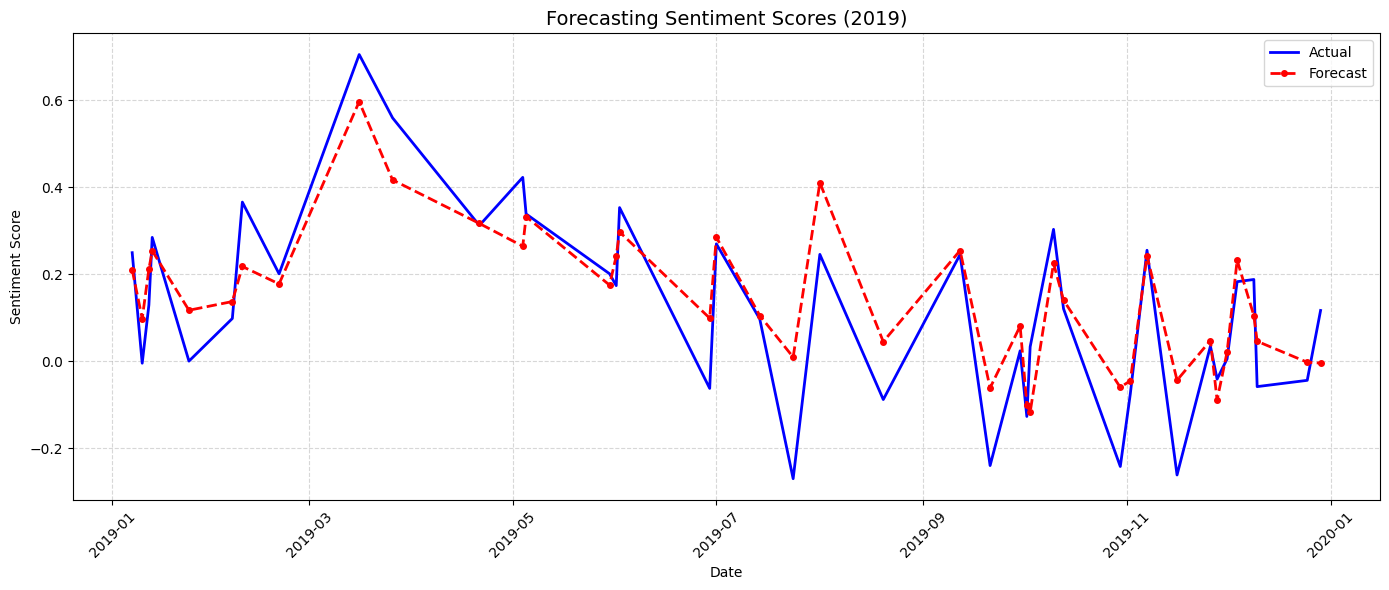

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_data['Date'], y_test, label='Actual', color='blue', linewidth=2)
plt.plot(test_data['Date'], y_pred, label='Forecast', color='red', linewidth=2, linestyle='--', marker='o', markersize=4)
plt.title('Forecasting Sentiment Scores (2019)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('forecast_plot.png')
plt.show()


#Business-1 Cluster-4

# Loading the Data of Businees-1 Cluster-**4**

In [ ]:
data = pd.read_csv('/content/B1_c4.csv')

# Prepareing data for the Seq2Seq model

In [ ]:
def prepare_for_model(sequences, forecast_steps=3, input_steps=10):
    X_values, X_timestamps, y_values = [], [], []
    for df in sequences:
        for i in range(len(df) - input_steps - forecast_steps + 1):
            x_vals = df['sentiment_score'].iloc[i:i+input_steps].values
            x_times = df['date'].iloc[i:i+input_steps].values
            y_vals = df['sentiment_score'].iloc[i+input_steps:i+input_steps+forecast_steps].values
            X_values.append(x_vals)
            X_timestamps.append(x_times)
            y_values.append(y_vals)
    X_values = torch.tensor(np.expand_dims(X_values, axis=-1), dtype=torch.float32)
    X_timestamps = torch.tensor(np.expand_dims(X_timestamps, axis=-1), dtype=torch.float32)
    y_values = torch.tensor(np.expand_dims(y_values, axis=-1), dtype=torch.float32)
    return X_values, X_timestamps, y_values

X_values, X_timestamps, y_values = prepare_for_model(data)

train_df = data[data['Date'].dt.year < 2019].copy()
test_df = data[data['Date'].dt.year == 2019].copy()

train_df = train_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})
test_df = test_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})

X_values_train, X_timestamps_train, y_values_train = prepare_for_model([train_df])
X_values_test, X_timestamps_test, y_values_test = prepare_for_model([test_df])


In [ ]:
class TimeAwareAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.time_decay = nn.Linear(1, hidden_dim)

    def forward(self, decoder_hidden, encoder_outputs, time_deltas):
        Q = self.query_proj(decoder_hidden).unsqueeze(1)
        K = self.key_proj(encoder_outputs)
        decay = torch.exp(-torch.abs(self.time_decay(time_deltas)))
        attn_scores = (Q * K * decay).sum(-1)
        attn_weights = F.softmax(attn_scores, dim=-1).unsqueeze(-1)
        context = (attn_weights * encoder_outputs).sum(1)
        return context

# Defining the Encoder and Decoder with dropout


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, dropout=dropout_rate)

    def forward(self, x):
        output, hidden = self.gru(x)
        return output, hidden.squeeze(0)

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRUCell(input_dim, hidden_dim)
        self.attn = TimeAwareAttention(hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, decoder_input, hidden, encoder_outputs, time_deltas):
        hidden = self.gru(decoder_input, hidden)
        context = self.attn(hidden, encoder_outputs, time_deltas)
        combined = torch.cat([hidden, context], dim=-1)
        output = self.fc(combined)
        return output, hidden

# Defining the Sequence to Sequence TimeAware class


In [ ]:
class Seq2SeqTimeAware(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)

    def forward(self, values, time_stamps, target=None, forecast_steps=3, teacher_forcing=True):
        B, T, _ = values.shape
        deltas = time_stamps[:, 1:, :] - time_stamps[:, :-1, :]
        deltas = torch.cat([deltas[:, 0:1, :], deltas], dim=1)
        enc_input = torch.cat([values, deltas], dim=-1)
        enc_outputs, hidden = self.encoder(enc_input)
        preds = []
        last_output = values[:, -1, :]
        last_time = time_stamps[:, -1, :]
        for step in range(forecast_steps):
            next_time = last_time + 1.0
            delta = (next_time.unsqueeze(1) - time_stamps).expand(-1, T, -1)
            dec_input = torch.cat([last_output, next_time - last_time], dim=-1)
            pred, hidden = self.decoder(dec_input, hidden, enc_outputs, delta)
            preds.append(pred.unsqueeze(1))
            if teacher_forcing and target is not None and step < target.shape[1]:
                last_output = target[:, step, :]
            else:
                last_output = pred.detach()
            last_time = next_time
        return torch.cat(preds, dim=1)



# Define the PrintEveryN callback

In [ ]:
class PrintEveryN:
    def __init__(self, N):
        self.N = N

    def __call__(self, epoch, train_loss, val_loss):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch+1:03}: Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


# Early stopping class

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.best_weights = None

    def check(self, val_loss, model):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def restore_best_weights(self, model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)


# Initializing Model, Loss function and optimizer

In [ ]:
model = Seq2SeqTimeAware(input_dim=2, hidden_dim=256)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
criterion = torch.nn.MSELoss()
forecast_steps = y_values_train.shape[1]

# Training and Evaluating the model

In [ ]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    preds = model(X_values_train, X_timestamps_train, target=y_values_train,
                  forecast_steps=forecast_steps, teacher_forcing=True)
    train_loss = criterion(preds, y_values_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_values_val, X_timestamps_val, target=None,
                          forecast_steps=forecast_steps, teacher_forcing=False)
        val_loss = criterion(val_preds, y_values_val).item()

    print_callback(epoch, train_loss.item(), val_loss)

    if early_stopping.check(val_loss, model):
        early_stopping.restore_best_weights(model)
        break

model.eval()
with torch.no_grad():
    preds = model(X_values_test, X_timestamps_test,
                  forecast_steps=forecast_steps, teacher_forcing=False)
    preds_np = preds.numpy().flatten()
    true_np = y_values_test.numpy().flatten()

Epoch 010: Loss = 0.0242, Val Loss = 0.0225
Epoch 020: Loss = 0.0192, Val Loss = 0.0232


In [ ]:
r2 = r2_score(true_np, preds_np)
mse = mean_squared_error(true_np, preds_np)
mae = mean_absolute_error(true_np, preds_np)
rmse = np.sqrt(mse)
ssip = np.sum((true_np - preds_np) ** 2)

print(f"\nEvaluation Metrics on Test Set (2019):")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"SSIP: {ssip:.4f}")



Evaluation Metrics on Test Set (2019):
R² Score: 0.6673
MSE: 0.0257
MAE: 0.1295
RMSE: 0.1604
SSIP: 1.2350


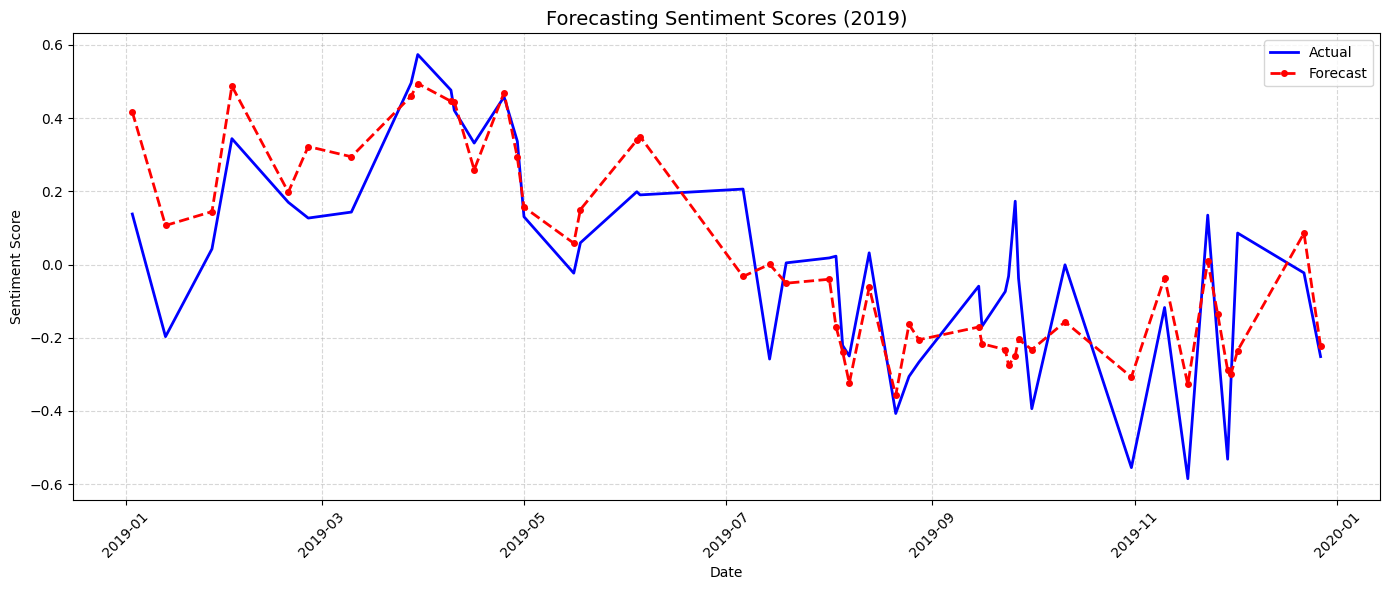

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_data['Date'], y_test, label='Actual', color='blue', linewidth=2)
plt.plot(test_data['Date'], y_pred, label='Forecast', color='red', linewidth=2, linestyle='--', marker='o', markersize=4)
plt.title('Forecasting Sentiment Scores (2019)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('forecast_plot.png')
plt.show()


#Business-2 Cluster-0

# Loading the Data of Businees-2 Cluster-0

In [ ]:
data = pd.read_csv('/content/B2_c0.csv')

# Prepareing data for the Seq2Seq model

In [ ]:
def prepare_for_model(sequences, forecast_steps=3, input_steps=10):
    X_values, X_timestamps, y_values = [], [], []
    for df in sequences:
        for i in range(len(df) - input_steps - forecast_steps + 1):
            x_vals = df['sentiment_score'].iloc[i:i+input_steps].values
            x_times = df['date'].iloc[i:i+input_steps].values
            y_vals = df['sentiment_score'].iloc[i+input_steps:i+input_steps+forecast_steps].values
            X_values.append(x_vals)
            X_timestamps.append(x_times)
            y_values.append(y_vals)
    X_values = torch.tensor(np.expand_dims(X_values, axis=-1), dtype=torch.float32)
    X_timestamps = torch.tensor(np.expand_dims(X_timestamps, axis=-1), dtype=torch.float32)
    y_values = torch.tensor(np.expand_dims(y_values, axis=-1), dtype=torch.float32)
    return X_values, X_timestamps, y_values

X_values, X_timestamps, y_values = prepare_for_model(data)

train_df = data[data['Date'].dt.year < 2019].copy()
test_df = data[data['Date'].dt.year == 2019].copy()

train_df = train_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})
test_df = test_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})

X_values_train, X_timestamps_train, y_values_train = prepare_for_model([train_df])
X_values_test, X_timestamps_test, y_values_test = prepare_for_model([test_df])


In [ ]:
class TimeAwareAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.time_decay = nn.Linear(1, hidden_dim)

    def forward(self, decoder_hidden, encoder_outputs, time_deltas):
        Q = self.query_proj(decoder_hidden).unsqueeze(1)
        K = self.key_proj(encoder_outputs)
        decay = torch.exp(-torch.abs(self.time_decay(time_deltas)))
        attn_scores = (Q * K * decay).sum(-1)
        attn_weights = F.softmax(attn_scores, dim=-1).unsqueeze(-1)
        context = (attn_weights * encoder_outputs).sum(1)
        return context

# Defining the Encoder and Decoder with dropout


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, dropout=dropout_rate)

    def forward(self, x):
        output, hidden = self.gru(x)
        return output, hidden.squeeze(0)

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRUCell(input_dim, hidden_dim)
        self.attn = TimeAwareAttention(hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, decoder_input, hidden, encoder_outputs, time_deltas):
        hidden = self.gru(decoder_input, hidden)
        context = self.attn(hidden, encoder_outputs, time_deltas)
        combined = torch.cat([hidden, context], dim=-1)
        output = self.fc(combined)
        return output, hidden

# Defining the Sequence to Sequence TimeAware class


In [ ]:
class Seq2SeqTimeAware(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)

    def forward(self, values, time_stamps, target=None, forecast_steps=3, teacher_forcing=True):
        B, T, _ = values.shape
        deltas = time_stamps[:, 1:, :] - time_stamps[:, :-1, :]
        deltas = torch.cat([deltas[:, 0:1, :], deltas], dim=1)
        enc_input = torch.cat([values, deltas], dim=-1)
        enc_outputs, hidden = self.encoder(enc_input)
        preds = []
        last_output = values[:, -1, :]
        last_time = time_stamps[:, -1, :]
        for step in range(forecast_steps):
            next_time = last_time + 1.0
            delta = (next_time.unsqueeze(1) - time_stamps).expand(-1, T, -1)
            dec_input = torch.cat([last_output, next_time - last_time], dim=-1)
            pred, hidden = self.decoder(dec_input, hidden, enc_outputs, delta)
            preds.append(pred.unsqueeze(1))
            if teacher_forcing and target is not None and step < target.shape[1]:
                last_output = target[:, step, :]
            else:
                last_output = pred.detach()
            last_time = next_time
        return torch.cat(preds, dim=1)



# Define the PrintEveryN callback

In [ ]:
class PrintEveryN:
    def __init__(self, N):
        self.N = N

    def __call__(self, epoch, train_loss, val_loss):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch+1:03}: Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


# Early stopping class

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.best_weights = None

    def check(self, val_loss, model):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def restore_best_weights(self, model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)


# Initializing Model, Loss function and optimizer

In [ ]:
model = Seq2SeqTimeAware(input_dim=2, hidden_dim=256)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
criterion = torch.nn.MSELoss()
forecast_steps = y_values_train.shape[1]

# Training and Evaluating the model

In [ ]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    preds = model(X_values_train, X_timestamps_train, target=y_values_train,
                  forecast_steps=forecast_steps, teacher_forcing=True)
    train_loss = criterion(preds, y_values_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_values_val, X_timestamps_val, target=None,
                          forecast_steps=forecast_steps, teacher_forcing=False)
        val_loss = criterion(val_preds, y_values_val).item()

    print_callback(epoch, train_loss.item(), val_loss)

    if early_stopping.check(val_loss, model):
        early_stopping.restore_best_weights(model)
        break

model.eval()
with torch.no_grad():
    preds = model(X_values_test, X_timestamps_test,
                  forecast_steps=forecast_steps, teacher_forcing=False)
    preds_np = preds.numpy().flatten()
    true_np = y_values_test.numpy().flatten()

Epoch 010: Loss = 0.0227, Val Loss = 0.0222
Epoch 020: Loss = 0.0171, Val Loss = 0.0192
Epoch 030: Loss = 0.0140, Val Loss = 0.0191


In [ ]:
r2 = r2_score(true_np, preds_np)
mse = mean_squared_error(true_np, preds_np)
mae = mean_absolute_error(true_np, preds_np)
rmse = np.sqrt(mse)
ssip = np.sum((true_np - preds_np) ** 2)

print(f"\nEvaluation Metrics on Test Set (2019):")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"SSIP: {ssip:.4f}")



Evaluation Metrics on Test Set (2019):
R² Score: 0.7031
MSE: 0.0156
MAE: 0.1004
RMSE: 0.1249
SSIP: 0.6867


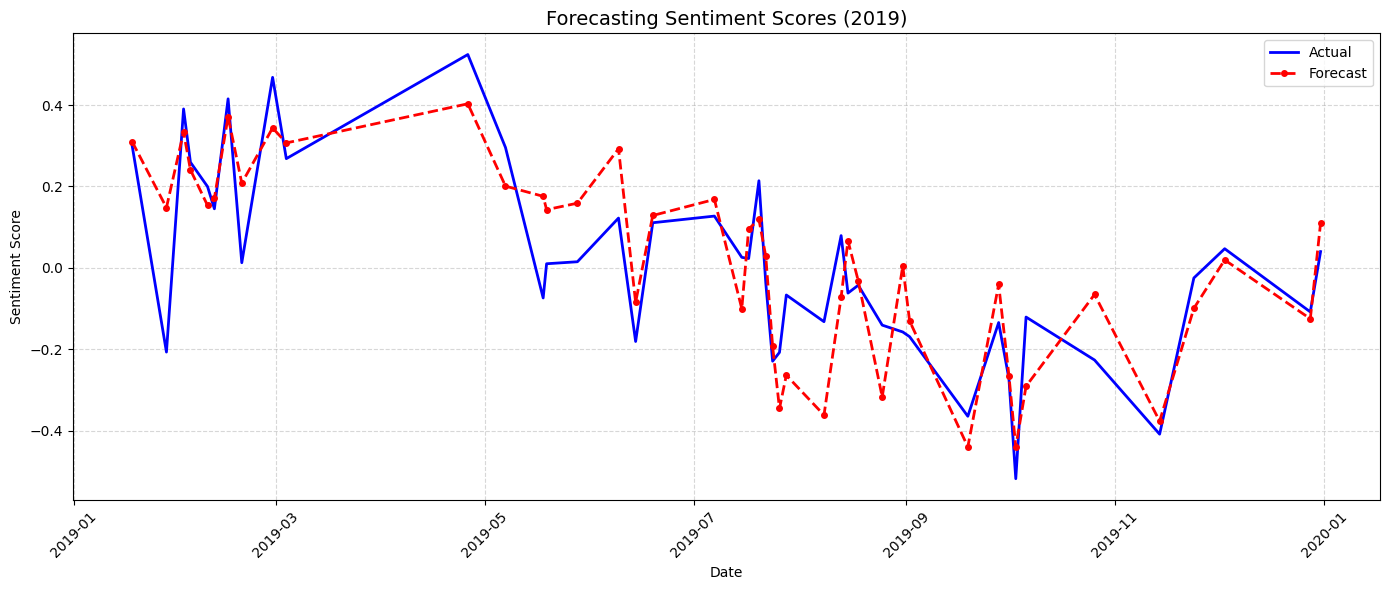

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_data['Date'], y_test, label='Actual', color='blue', linewidth=2)
plt.plot(test_data['Date'], y_pred, label='Forecast', color='red', linewidth=2, linestyle='--', marker='o', markersize=4)
plt.title('Forecasting Sentiment Scores (2019)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('forecast_plot.png')
plt.show()


#Business-2 Cluster-3

# Loading the Data of Businees-2 Cluster-**3**

In [ ]:
data = pd.read_csv('/content/B2_c3.csv')

# Prepareing data for the Seq2Seq model

In [ ]:
def prepare_for_model(sequences, forecast_steps=3, input_steps=10):
    X_values, X_timestamps, y_values = [], [], []
    for df in sequences:
        for i in range(len(df) - input_steps - forecast_steps + 1):
            x_vals = df['sentiment_score'].iloc[i:i+input_steps].values
            x_times = df['date'].iloc[i:i+input_steps].values
            y_vals = df['sentiment_score'].iloc[i+input_steps:i+input_steps+forecast_steps].values
            X_values.append(x_vals)
            X_timestamps.append(x_times)
            y_values.append(y_vals)
    X_values = torch.tensor(np.expand_dims(X_values, axis=-1), dtype=torch.float32)
    X_timestamps = torch.tensor(np.expand_dims(X_timestamps, axis=-1), dtype=torch.float32)
    y_values = torch.tensor(np.expand_dims(y_values, axis=-1), dtype=torch.float32)
    return X_values, X_timestamps, y_values

X_values, X_timestamps, y_values = prepare_for_model(data)

train_df = data[data['Date'].dt.year < 2019].copy()
test_df = data[data['Date'].dt.year == 2019].copy()

train_df = train_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})
test_df = test_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})

X_values_train, X_timestamps_train, y_values_train = prepare_for_model([train_df])
X_values_test, X_timestamps_test, y_values_test = prepare_for_model([test_df])


In [ ]:
class TimeAwareAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.time_decay = nn.Linear(1, hidden_dim)

    def forward(self, decoder_hidden, encoder_outputs, time_deltas):
        Q = self.query_proj(decoder_hidden).unsqueeze(1)
        K = self.key_proj(encoder_outputs)
        decay = torch.exp(-torch.abs(self.time_decay(time_deltas)))
        attn_scores = (Q * K * decay).sum(-1)
        attn_weights = F.softmax(attn_scores, dim=-1).unsqueeze(-1)
        context = (attn_weights * encoder_outputs).sum(1)
        return context

# Defining the Encoder and Decoder with dropout


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, dropout=dropout_rate)

    def forward(self, x):
        output, hidden = self.gru(x)
        return output, hidden.squeeze(0)

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRUCell(input_dim, hidden_dim)
        self.attn = TimeAwareAttention(hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, decoder_input, hidden, encoder_outputs, time_deltas):
        hidden = self.gru(decoder_input, hidden)
        context = self.attn(hidden, encoder_outputs, time_deltas)
        combined = torch.cat([hidden, context], dim=-1)
        output = self.fc(combined)
        return output, hidden

#Defining the Sequence to Sequence TimeAware class


In [ ]:
class Seq2SeqTimeAware(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)

    def forward(self, values, time_stamps, target=None, forecast_steps=3, teacher_forcing=True):
        B, T, _ = values.shape
        deltas = time_stamps[:, 1:, :] - time_stamps[:, :-1, :]
        deltas = torch.cat([deltas[:, 0:1, :], deltas], dim=1)
        enc_input = torch.cat([values, deltas], dim=-1)
        enc_outputs, hidden = self.encoder(enc_input)
        preds = []
        last_output = values[:, -1, :]
        last_time = time_stamps[:, -1, :]
        for step in range(forecast_steps):
            next_time = last_time + 1.0
            delta = (next_time.unsqueeze(1) - time_stamps).expand(-1, T, -1)
            dec_input = torch.cat([last_output, next_time - last_time], dim=-1)
            pred, hidden = self.decoder(dec_input, hidden, enc_outputs, delta)
            preds.append(pred.unsqueeze(1))
            if teacher_forcing and target is not None and step < target.shape[1]:
                last_output = target[:, step, :]
            else:
                last_output = pred.detach()
            last_time = next_time
        return torch.cat(preds, dim=1)



# Define the PrintEveryN callback

In [ ]:
class PrintEveryN:
    def __init__(self, N):
        self.N = N

    def __call__(self, epoch, train_loss, val_loss):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch+1:03}: Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


# Early stopping class

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.best_weights = None

    def check(self, val_loss, model):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def restore_best_weights(self, model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)


# Initializing Model, Loss function and optimizer

In [ ]:
model = Seq2SeqTimeAware(input_dim=2, hidden_dim=256)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
criterion = torch.nn.MSELoss()
forecast_steps = y_values_train.shape[1]

# Training and Evaluating the model

In [ ]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    preds = model(X_values_train, X_timestamps_train, target=y_values_train,
                  forecast_steps=forecast_steps, teacher_forcing=True)
    train_loss = criterion(preds, y_values_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_values_val, X_timestamps_val, target=None,
                          forecast_steps=forecast_steps, teacher_forcing=False)
        val_loss = criterion(val_preds, y_values_val).item()

    print_callback(epoch, train_loss.item(), val_loss)

    if early_stopping.check(val_loss, model):
        early_stopping.restore_best_weights(model)
        break

model.eval()
with torch.no_grad():
    preds = model(X_values_test, X_timestamps_test,
                  forecast_steps=forecast_steps, teacher_forcing=False)
    preds_np = preds.numpy().flatten()
    true_np = y_values_test.numpy().flatten()

Epoch 010: Loss = 0.0302, Val Loss = 0.0202
Epoch 020: Loss = 0.0193, Val Loss = 0.0191
Epoch 030: Loss = 0.0146, Val Loss = 0.0193


In [ ]:
r2 = r2_score(true_np, preds_np)
mse = mean_squared_error(true_np, preds_np)
mae = mean_absolute_error(true_np, preds_np)
rmse = np.sqrt(mse)
ssip = np.sum((true_np - preds_np) ** 2)

print(f"\nEvaluation Metrics on Test Set (2019):")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"SSIP: {ssip:.4f}")



Evaluation Metrics on Test Set (2019):
R² Score: 0.7251
MSE: 0.0207
MAE: 0.1061
RMSE: 0.1440
SSIP: 1.1401


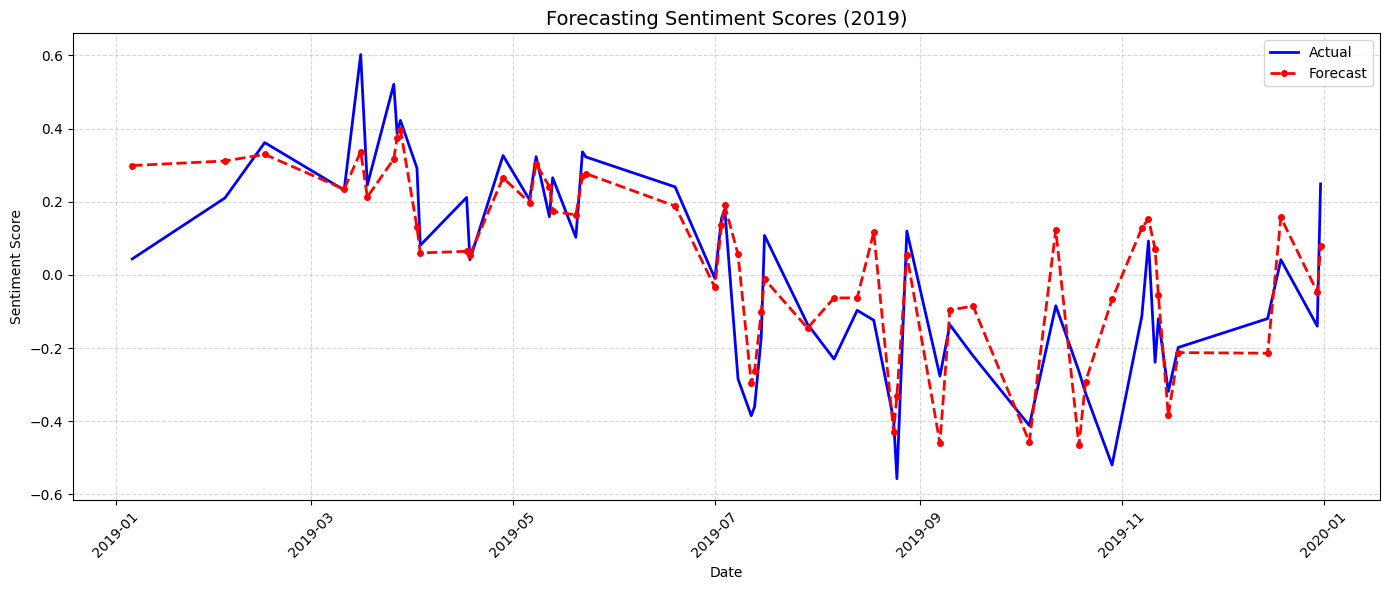

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_data['Date'], y_test, label='Actual', color='blue', linewidth=2)
plt.plot(test_data['Date'], y_pred, label='Forecast', color='red', linewidth=2, linestyle='--', marker='o', markersize=4)
plt.title('Forecasting Sentiment Scores (2019)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('forecast_plot.png')
plt.show()


#Business-3 Cluster-1

# Loading the Data of Businees-3 Cluster-1

In [ ]:
data = pd.read_csv('/content/B3_c1.csv')

# Prepareing data for the Seq2Seq model

In [ ]:
def prepare_for_model(sequences, forecast_steps=3, input_steps=10):
    X_values, X_timestamps, y_values = [], [], []
    for df in sequences:
        for i in range(len(df) - input_steps - forecast_steps + 1):
            x_vals = df['sentiment_score'].iloc[i:i+input_steps].values
            x_times = df['date'].iloc[i:i+input_steps].values
            y_vals = df['sentiment_score'].iloc[i+input_steps:i+input_steps+forecast_steps].values
            X_values.append(x_vals)
            X_timestamps.append(x_times)
            y_values.append(y_vals)
    X_values = torch.tensor(np.expand_dims(X_values, axis=-1), dtype=torch.float32)
    X_timestamps = torch.tensor(np.expand_dims(X_timestamps, axis=-1), dtype=torch.float32)
    y_values = torch.tensor(np.expand_dims(y_values, axis=-1), dtype=torch.float32)
    return X_values, X_timestamps, y_values

X_values, X_timestamps, y_values = prepare_for_model(data)

train_df = data[data['Date'].dt.year < 2019].copy()
test_df = data[data['Date'].dt.year == 2019].copy()

train_df = train_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})
test_df = test_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})

X_values_train, X_timestamps_train, y_values_train = prepare_for_model([train_df])
X_values_test, X_timestamps_test, y_values_test = prepare_for_model([test_df])


In [ ]:
class TimeAwareAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.time_decay = nn.Linear(1, hidden_dim)

    def forward(self, decoder_hidden, encoder_outputs, time_deltas):
        Q = self.query_proj(decoder_hidden).unsqueeze(1)
        K = self.key_proj(encoder_outputs)
        decay = torch.exp(-torch.abs(self.time_decay(time_deltas)))
        attn_scores = (Q * K * decay).sum(-1)
        attn_weights = F.softmax(attn_scores, dim=-1).unsqueeze(-1)
        context = (attn_weights * encoder_outputs).sum(1)
        return context

# Defining the Encoder and Decoder with dropout


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, dropout=dropout_rate)

    def forward(self, x):
        output, hidden = self.gru(x)
        return output, hidden.squeeze(0)

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRUCell(input_dim, hidden_dim)
        self.attn = TimeAwareAttention(hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, decoder_input, hidden, encoder_outputs, time_deltas):
        hidden = self.gru(decoder_input, hidden)
        context = self.attn(hidden, encoder_outputs, time_deltas)
        combined = torch.cat([hidden, context], dim=-1)
        output = self.fc(combined)
        return output, hidden

# Defining the Sequence to Sequence TimeAware class


In [ ]:
class Seq2SeqTimeAware(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)

    def forward(self, values, time_stamps, target=None, forecast_steps=3, teacher_forcing=True):
        B, T, _ = values.shape
        deltas = time_stamps[:, 1:, :] - time_stamps[:, :-1, :]
        deltas = torch.cat([deltas[:, 0:1, :], deltas], dim=1)
        enc_input = torch.cat([values, deltas], dim=-1)
        enc_outputs, hidden = self.encoder(enc_input)
        preds = []
        last_output = values[:, -1, :]
        last_time = time_stamps[:, -1, :]
        for step in range(forecast_steps):
            next_time = last_time + 1.0
            delta = (next_time.unsqueeze(1) - time_stamps).expand(-1, T, -1)
            dec_input = torch.cat([last_output, next_time - last_time], dim=-1)
            pred, hidden = self.decoder(dec_input, hidden, enc_outputs, delta)
            preds.append(pred.unsqueeze(1))
            if teacher_forcing and target is not None and step < target.shape[1]:
                last_output = target[:, step, :]
            else:
                last_output = pred.detach()
            last_time = next_time
        return torch.cat(preds, dim=1)



# Define the PrintEveryN callback

In [ ]:
class PrintEveryN:
    def __init__(self, N):
        self.N = N

    def __call__(self, epoch, train_loss, val_loss):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch+1:03}: Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


# Early stopping class

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.best_weights = None

    def check(self, val_loss, model):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def restore_best_weights(self, model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)


# Initializing Model, Loss function and optimizer

In [ ]:
model = Seq2SeqTimeAware(input_dim=2, hidden_dim=256)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
criterion = torch.nn.MSELoss()
forecast_steps = y_values_train.shape[1]

# Training and Evaluating the model

In [ ]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    preds = model(X_values_train, X_timestamps_train, target=y_values_train,
                  forecast_steps=forecast_steps, teacher_forcing=True)
    train_loss = criterion(preds, y_values_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_values_val, X_timestamps_val, target=None,
                          forecast_steps=forecast_steps, teacher_forcing=False)
        val_loss = criterion(val_preds, y_values_val).item()

    print_callback(epoch, train_loss.item(), val_loss)

    if early_stopping.check(val_loss, model):
        early_stopping.restore_best_weights(model)
        break

model.eval()
with torch.no_grad():
    preds = model(X_values_test, X_timestamps_test,
                  forecast_steps=forecast_steps, teacher_forcing=False)
    preds_np = preds.numpy().flatten()
    true_np = y_values_test.numpy().flatten()

Epoch 010: Loss = 0.0275, Val Loss = 0.0264
Epoch 020: Loss = 0.0227, Val Loss = 0.0211
Epoch 030: Loss = 0.0190, Val Loss = 0.0178
Epoch 040: Loss = 0.0138, Val Loss = 0.0166
Epoch 050: Loss = 0.0121, Val Loss = 0.0161
Epoch 060: Loss = 0.0119, Val Loss = 0.0170


In [ ]:
r2 = r2_score(true_np, preds_np)
mse = mean_squared_error(true_np, preds_np)
mae = mean_absolute_error(true_np, preds_np)
rmse = np.sqrt(mse)
ssip = np.sum((true_np - preds_np) ** 2)

print(f"\nEvaluation Metrics on Test Set (2019):")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"SSIP: {ssip:.4f}")



Evaluation Metrics on Test Set (2019):
R² Score: 0.5765
MSE: 0.0199
MAE: 0.1050
RMSE: 0.1412
SSIP: 1.0174


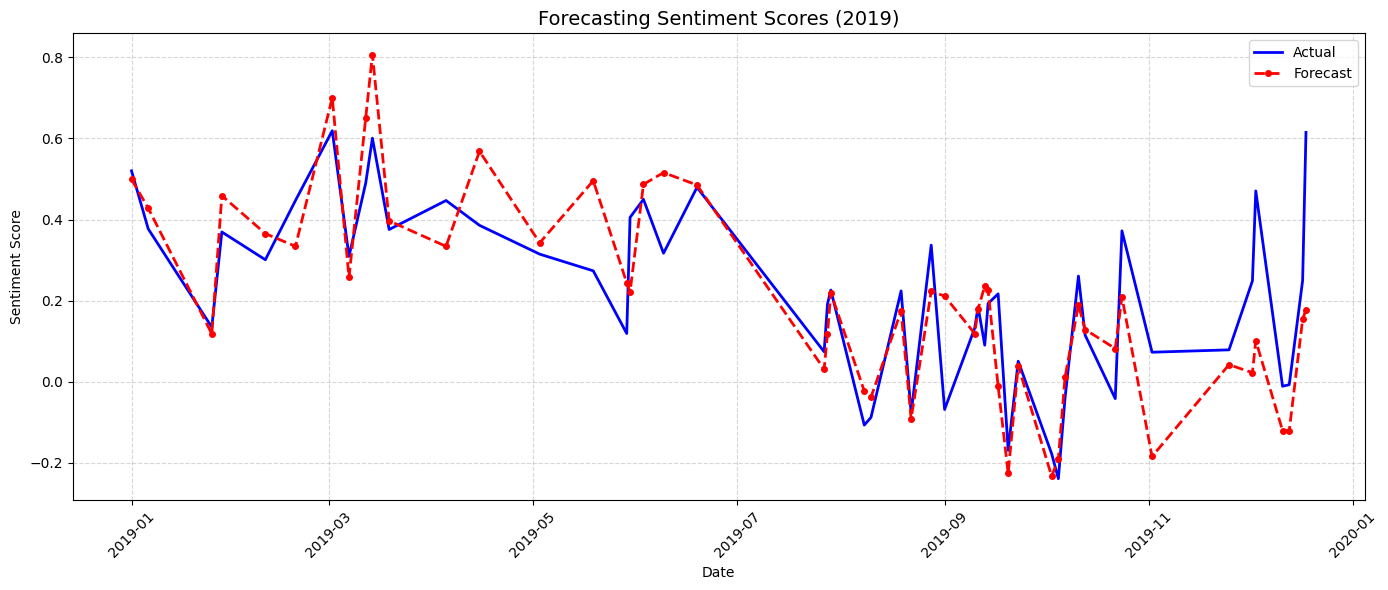

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_data['Date'], y_test, label='Actual', color='blue', linewidth=2)
plt.plot(test_data['Date'], y_pred, label='Forecast', color='red', linewidth=2, linestyle='--', marker='o', markersize=4)
plt.title('Forecasting Sentiment Scores (2019)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('forecast_plot.png')
plt.show()


# Cafe Cluster-1

# Loading the Data of Cafe Cluster-1

In [ ]:
data = pd.read_csv('/content/Cafe_c1.csv')

# Prepareing data for the Seq2Seq model

In [ ]:
def prepare_for_model(sequences, forecast_steps=3, input_steps=10):
    X_values, X_timestamps, y_values = [], [], []
    for df in sequences:
        for i in range(len(df) - input_steps - forecast_steps + 1):
            x_vals = df['sentiment_score'].iloc[i:i+input_steps].values
            x_times = df['date'].iloc[i:i+input_steps].values
            y_vals = df['sentiment_score'].iloc[i+input_steps:i+input_steps+forecast_steps].values
            X_values.append(x_vals)
            X_timestamps.append(x_times)
            y_values.append(y_vals)
    X_values = torch.tensor(np.expand_dims(X_values, axis=-1), dtype=torch.float32)
    X_timestamps = torch.tensor(np.expand_dims(X_timestamps, axis=-1), dtype=torch.float32)
    y_values = torch.tensor(np.expand_dims(y_values, axis=-1), dtype=torch.float32)
    return X_values, X_timestamps, y_values

X_values, X_timestamps, y_values = prepare_for_model(data)

train_df = data[data['Date'].dt.year < 2019].copy()
test_df = data[data['Date'].dt.year == 2019].copy()

train_df = train_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})
test_df = test_df.rename(columns={'Date': 'date', 'Sentiment': 'sentiment_score'})

X_values_train, X_timestamps_train, y_values_train = prepare_for_model([train_df])
X_values_test, X_timestamps_test, y_values_test = prepare_for_model([test_df])


In [ ]:
class TimeAwareAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.time_decay = nn.Linear(1, hidden_dim)

    def forward(self, decoder_hidden, encoder_outputs, time_deltas):
        Q = self.query_proj(decoder_hidden).unsqueeze(1)
        K = self.key_proj(encoder_outputs)
        decay = torch.exp(-torch.abs(self.time_decay(time_deltas)))
        attn_scores = (Q * K * decay).sum(-1)
        attn_weights = F.softmax(attn_scores, dim=-1).unsqueeze(-1)
        context = (attn_weights * encoder_outputs).sum(1)
        return context

# Defining the Encoder and Decoder with dropout


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, dropout=dropout_rate)

    def forward(self, x):
        output, hidden = self.gru(x)
        return output, hidden.squeeze(0)

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.gru = nn.GRUCell(input_dim, hidden_dim)
        self.attn = TimeAwareAttention(hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, decoder_input, hidden, encoder_outputs, time_deltas):
        hidden = self.gru(decoder_input, hidden)
        context = self.attn(hidden, encoder_outputs, time_deltas)
        combined = torch.cat([hidden, context], dim=-1)
        output = self.fc(combined)
        return output, hidden

# Defining the Sequence to Sequence TimeAware class


In [ ]:
class Seq2SeqTimeAware(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)

    def forward(self, values, time_stamps, target=None, forecast_steps=3, teacher_forcing=True):
        B, T, _ = values.shape
        deltas = time_stamps[:, 1:, :] - time_stamps[:, :-1, :]
        deltas = torch.cat([deltas[:, 0:1, :], deltas], dim=1)
        enc_input = torch.cat([values, deltas], dim=-1)
        enc_outputs, hidden = self.encoder(enc_input)
        preds = []
        last_output = values[:, -1, :]
        last_time = time_stamps[:, -1, :]
        for step in range(forecast_steps):
            next_time = last_time + 1.0
            delta = (next_time.unsqueeze(1) - time_stamps).expand(-1, T, -1)
            dec_input = torch.cat([last_output, next_time - last_time], dim=-1)
            pred, hidden = self.decoder(dec_input, hidden, enc_outputs, delta)
            preds.append(pred.unsqueeze(1))
            if teacher_forcing and target is not None and step < target.shape[1]:
                last_output = target[:, step, :]
            else:
                last_output = pred.detach()
            last_time = next_time
        return torch.cat(preds, dim=1)



# Define the PrintEveryN callback

In [ ]:
class PrintEveryN:
    def __init__(self, N):
        self.N = N

    def __call__(self, epoch, train_loss, val_loss):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch+1:03}: Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


# Early stopping class

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.best_weights = None

    def check(self, val_loss, model):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def restore_best_weights(self, model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)


# Initializing Model, Loss function and optimizer

In [ ]:
model = Seq2SeqTimeAware(input_dim=2, hidden_dim=256)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
criterion = torch.nn.MSELoss()
forecast_steps = y_values_train.shape[1]

# Training and Evaluating the model

In [ ]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    preds = model(X_values_train, X_timestamps_train, target=y_values_train,
                  forecast_steps=forecast_steps, teacher_forcing=True)
    train_loss = criterion(preds, y_values_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_values_val, X_timestamps_val, target=None,
                          forecast_steps=forecast_steps, teacher_forcing=False)
        val_loss = criterion(val_preds, y_values_val).item()

    print_callback(epoch, train_loss.item(), val_loss)

    if early_stopping.check(val_loss, model):
        early_stopping.restore_best_weights(model)
        break

model.eval()
with torch.no_grad():
    preds = model(X_values_test, X_timestamps_test,
                  forecast_steps=forecast_steps, teacher_forcing=False)
    preds_np = preds.numpy().flatten()
    true_np = y_values_test.numpy().flatten()

Epoch 10: Loss = 0.0214, Val Loss = 0.0154
Epoch 20: Loss = 0.0170, Val Loss = 0.0120


In [ ]:
r2 = r2_score(true_np, preds_np)
mse = mean_squared_error(true_np, preds_np)
mae = mean_absolute_error(true_np, preds_np)
rmse = np.sqrt(mse)
ssip = np.sum((true_np - preds_np) ** 2)

print(f"\nEvaluation Metrics on Test Set (2019):")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"SSIP: {ssip:.4f}")



Evaluation Metrics on Test Set (2019):
R² Score: 0.6892
MSE: 0.0179
MAE: 0.1045
RMSE: 0.1339
SSIP: 0.7715


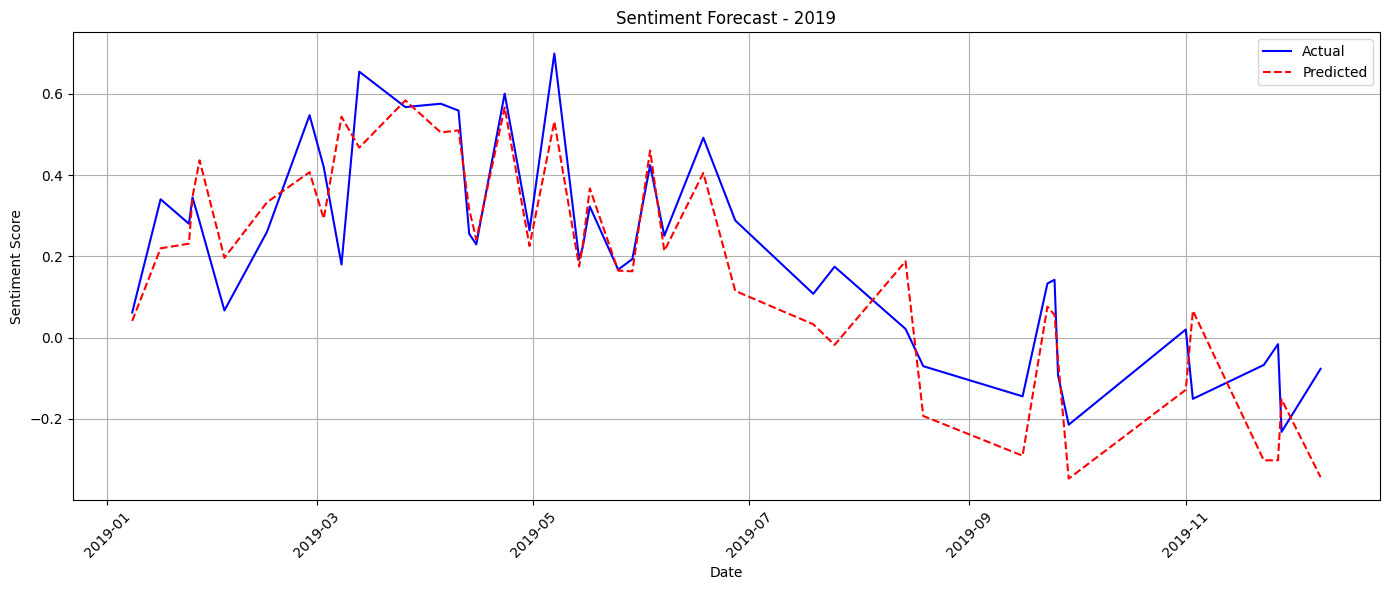

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_data['Date'], y_test, label='Actual', color='blue')
plt.plot(test_data['Date'], y_pred, label='Predicted', color='red', linestyle='--')
plt.title("Sentiment Forecast - 2019")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Insights from Sentiment Score Forecasting:

#### We implemented and compared multiple deep learning models for forecasting sentiment scores over time:

#### 1.Recurrent Neural Network (RNN)

#### 2.Long Short-Term Memory (LSTM)

#### 3.CNN + LSTM hybrid model

#### 4.Time-aware Seq2Seq Encoder-Decoder model


#### To model time gaps between reviews and better capture temporal dynamics, I designed a Time-aware Seq2Seq Encoder-Decoder.

#### The Time-aware Seq2Seq model outperformed all previous models in terms of:

## Higher R² score

## Lower Mean Squared Error (MSE) and Mean Absolute Error (MAE)

## This shows that explicitly modeling time intervals and sequence structure significantly boosts the accuracy and robustness of sentiment forecasting.